In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install nltk
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
!{sys.executable} -m pip install scipy
from scipy import stats

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/keanu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/keanu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/keanu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from perceval.backends.core.github import GitHub
import os,json
import nltk.data
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import augur
import datetime as dt
import sqlalchemy as s
import matplotlib.pyplot as plot
import matplotlib.dates as mdates
import pandas as pd
%matplotlib inline

## Load

First loads the users data from 'augur.config.json' so will take the Database information (e.g. name of database, port of database). Then connects to the database using augur.App.github_issues() and takes the details of the database and connects to to the database using charset 'utf8'. It also makes a connection to piper_reader, it then determines if 'github_issues_2' is in the Database if so it stores the git repositories into 'df1'. It then loads the SentimentIntensityAnalyzer from NLTK (Natural Language Tool Kit) and stores the table 'github_issues_2' which has all the github issues into 'df_users'.

In [ ]:
if("notebooks" not in os.getcwd()):
    os.chdir("notebooks")
augurApp = augur.Application('../augur.config.json')
connect,list1,path = augurApp.github_issues()
DB_STR = 'mysql+pymysql://{}:{}@{}:{}/{}?charset=utf8'.format(
            list1[0], list1[1], list1[2],\
            list1[3], list1[4]
        )
db = s.create_engine(DB_STR)

table_names = s.inspect(db).get_table_names()
print(table_names)

if("github_issues_2" in table_names):
    lists_createdSQL = s.sql.text("""SELECT repo FROM github_issues_2""")
    df1 = pd.read_sql(lists_createdSQL, db)
    #print(df1)
    val = True

    

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sid = SentimentIntensityAnalyzer()
col = 'score','sentiment'

SQL = """SELECT * FROM github_issues_2"""
df_users =  pd.read_sql(SQL, db)
print(df_users.head())
print(df_users.tail())

## Sentiment Scores:

Groups all the messages by subject and then iterates through the subjects, it then iterates through the different messages in the subject and feeds this to the tokenizer which breaks the message into different parts and gives the sentiment for them and then finds the average of the parts. This is then added to df3.

In [8]:
grouped = df_users.groupby('subject').groups
num = 0
col = 'score','sentiment'
columns1 = 'augurmsgID',"backend_name",'repo_link',"owner","repo","subject",\
          "status","category","issue_number","timestamp",\
          "issue_id","user","body"
df3 = pd.DataFrame(columns=col)
df_list = pd.DataFrame(columns = columns1)
df_list = df_list.append(df_users)
for group in grouped:
    #print(group)
    issue_num = (df_users.loc[df_users['subject'] == group]['issue_number']).values
    messages = (df_users.loc[df_users['subject'] == group]['body']).tolist()
    id1 = (df_users.loc[df_users['subject'] == group]['body']).tolist()
    #print("Issue number: ",issue_num[0])
    #break
    for i in messages:
        #print(i)
        sentences = tokenizer.tokenize(i)
        compound = 0
        part = 0
        sentiment = "Positive"
        for sentence in sentences:
            scores = sid.polarity_scores(sentence)
            compound+=scores['compound']
            part+=1
            #print(sentence,scores)
            #if(scores['compound'] < 0.1):
            #    print(sentence,scores['compound'])
        if(part == 0):
            avg = 0
        else:
            avg = compound/part
            avg = round(avg,3)
        if(avg == 0):
            sentiment = "Neutral"
        elif(avg < 0):
            sentiment = "Negative"
        li = [ [avg,sentiment]]
        df_temp = pd.DataFrame(li,columns=col)
        df3 = df3.append(df_temp)
        #if(avg < -0.5):
            #print(i,avg)
            #print("\n\n\n\n\n\n")
    #if(num == 40):
    #    break
    num+=1
    #print("\n\n\n")
print(num)

481


## Combine

Combines the dataframe with all the messages and joins that with the scores for the messages. Then uploads this to the database as 'github_issues_sentiment_scores_2'.

In [9]:
#print(df3)
#print(df_list)
df3 = df3.reset_index(drop=True)
#print(df3.head())
df_list = df_list.reset_index(drop=True)
combine = (df_list.join(df3))

print(combine.head())

combine.to_sql(name='github_issues_sentiment_scores_2',\
               con=db,if_exists='replace',index=False)

## Graphs

Takes all the git repositories in 'combine' and groups by the column 'repo_link' and gets the dates and sentiment scores and plots a graph based on this.

(126,)
(126,)


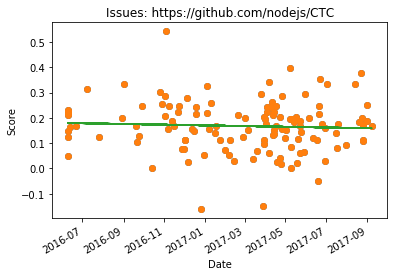

(357,)
(357,)


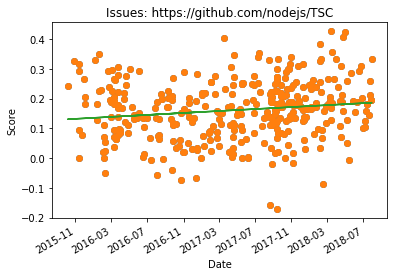

In [15]:
repos = combine.groupby('repo_link')
x = 0
for repo in repos:
    fin_dates = []
    fin_values = []
    dates = []
    values = []
    mail_list = None
    j = 0
    rep = (combine.loc[combine['repo_link'] == repo[0]])
    grouped = rep.groupby('subject').groups
    for group in grouped:
        #print(group)
        dates = (combine.loc[combine['subject'] == group]['timestamp']).tolist()
        values = (combine.loc[combine['subject'] == group]['score']).unique().tolist()
        #print("Issue number: ",issue_num[0])
        x = np.array(dates)
        dates = np.unique(x)
        #print(type(x[0]))
        #print(dates)
        dates = [dt.datetime.strptime(d[:10],'%Y-%m-%d').date() for d in x]
        #print(dates)
        dates1 = [x for x in dates]
        values = sum(values[0:len(values)])/len(values)
        fin_dates.append(dates1[0])
        fin_values.append(values)
        num+=1
        j+=1
    fin_dates = mdates.date2num(fin_dates)
    fin_values = np.asarray(fin_values)
    print(fin_dates.shape)
    print(fin_values.shape)
    plot.plot_date(fin_dates, fin_values)
    #plot.plot(fin_dates,fin_values)
    plot.gcf().autofmt_xdate()
    plot.title("Issues: "+ str(repo[0]))
    plot.ylabel('Score')
    plot.xlabel('Date')
    #print(fin_dates)
    slope, intercept, r_value, p_value, std_err = stats.linregress(fin_dates,fin_values)
    line = slope*fin_dates+intercept
    plot.plot(fin_dates,fin_values,'o', fin_dates, line)
    #plot.savefig('foo' + str(x) + '.png')
    #x+=1
    plot.show()